# 📊 PCA Forecasting Inference Notebook
Use your trained CNN model to predict future PCA graphs from 15-year input sequences.

---

🔧 Cell 2 – Imports

In [4]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from pathlib import Path

⚙️ Cell 3 – Config

In [6]:
# --- Config ---
import pandas as pd
import random

MODEL_PATH = "cnn_pca_forecaster.pt"
IMG_SIZE = (256, 128)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- Load and sample metadata for a 2-year pair ---
meta = pd.read_csv("pca_graph_pairs/pairs_metadata.csv")
meta_2yr = meta[meta["forecast_years"] == 2]

# Randomly select one pair
sample = meta_2yr.sample(1).iloc[0]
INPUT_IMG_PATH = sample["input_img"]
OUTPUT_IMG_PATH = sample["output_img"]

print("📥 Input image selected:", INPUT_IMG_PATH)
print("📈 Target output image selected:", OUTPUT_IMG_PATH)

📥 Input image selected: pca_graph_pairs/inputs/chunk_202007_to_202101_2yr.png
📈 Target output image selected: pca_graph_pairs/outputs_2yr/chunk_202007_to_202101_2yr.png


🔁 Replace the INPUT_IMG_PATH and OUTPUT_IMG_PATH with real file names from your dataset.

🧠 Cell 4 – Model Definition

In [17]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        return self.decoder(x)

In [24]:
# Instantiate and load the model
model = SimpleCNN()
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model = model.to(DEVICE)
model.eval()

print("✅ Model loaded and ready.")

✅ Model loaded and ready.


🔮 Cell 6 – Run Inference on Input Image

In [27]:
transform = transforms.ToTensor()

# Load input image
input_img = Image.open(INPUT_IMG_PATH).convert("RGB").resize(IMG_SIZE)
input_tensor = transform(input_img).unsqueeze(0).to(DEVICE)

# Predict
with torch.no_grad():
    pred_tensor = model(input_tensor)

# Convert to image
pred_img = to_pil_image(pred_tensor.squeeze(0).cpu())
pred_img.save("predicted_future.png")
print("📈 Saved prediction to: predicted_future.png")
pred_img.show()

📈 Saved prediction to: predicted_future.png


🧪 Cell 7 – Compare with Ground Truth

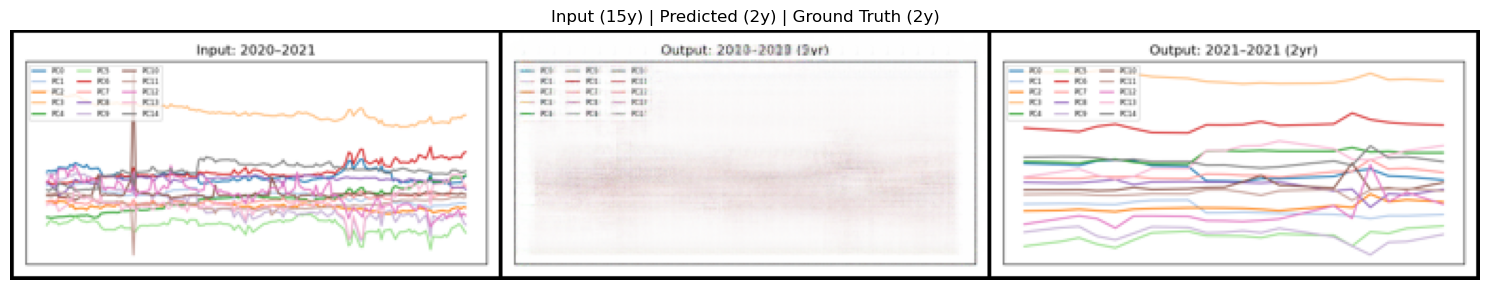

In [29]:
# Load ground truth
truth_img = Image.open(OUTPUT_IMG_PATH).convert("RGB").resize(IMG_SIZE)
truth_tensor = transform(truth_img)

# Combine input, predicted, and ground truth
grid = make_grid([
    input_tensor.squeeze(0).cpu(),
    pred_tensor.squeeze(0).cpu(),
    truth_tensor
], nrow=3)

plt.figure(figsize=(15, 5))
plt.imshow(grid.permute(1, 2, 0))
plt.title("Input (15y) | Predicted (2y) | Ground Truth (2y)")
plt.axis("off")
plt.tight_layout()
plt.show()